# Playing The Angel: Playing `RankNET`

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import combinations, repeat
import matplotlib.pyplot as plt
import pandas as pd

from modules import performance_measures_helper as pms
from modules.constants import START_TRAINING_DATE_CUT, END_TRAINING_DATE_CUT
from importlib import reload
reload(pms) # performance_measures_helper.py still alpha. Continuous reloadings needed

## Introduction: Query-Document-Features Toy Data

In [4]:
# 20 label-queries, variable number of documents for each query and 10 features for each pair (query-document)
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

In [5]:
query

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18,
       18, 18, 18, 18, 18

In [9]:
# The Scheme: Pairing of Features and Responses (Scores)

In [121]:
# Paring Input data (q,d_i) ~ (s_i)
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

## Translating Into The Portfolio Problem: 
## EOM Rebalance Event-Stock Picking

In [12]:
daily_rets = pd.read_csv("data/config/20220814_daily_raw_returns_merged.csv", index_col="Date", parse_dates=True, na_values="#N/A")

In [13]:
monthly_rets = daily_rets.resample("BM").apply(pms.net_cumreturn, last_row=True)

Some checks

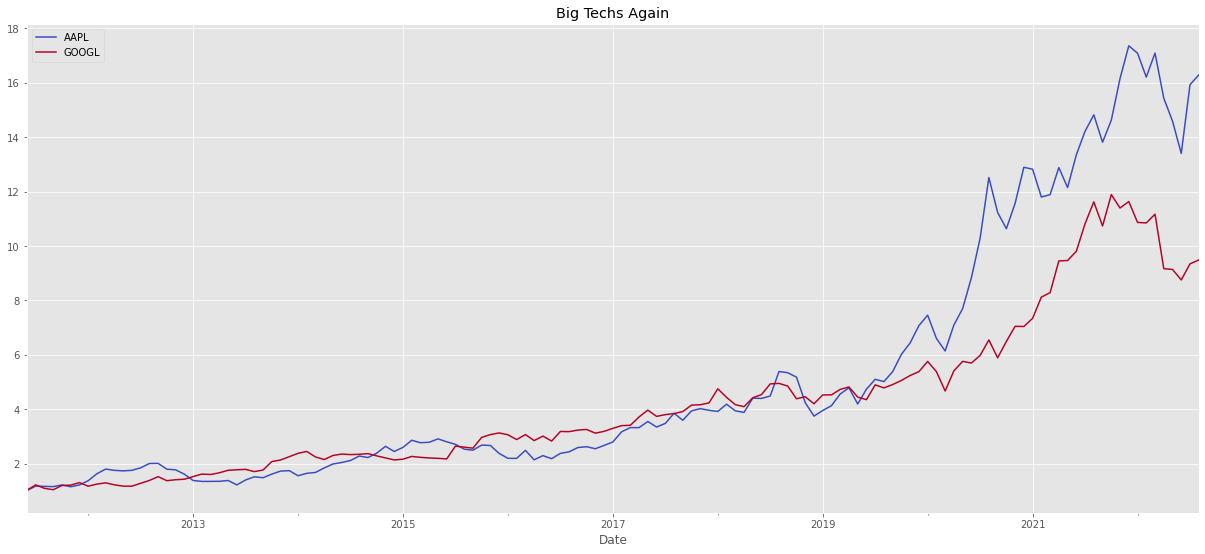

In [14]:
plt.style.use("ggplot")
(1+monthly_rets[["AAPL","GOOGL"]]).cumprod().plot(figsize=(21,9), title="Big Techs Again", cmap="coolwarm");

In [15]:
monthly_rets.tail()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-29,-0.097278,NaN,0.028493,-0.035418,-0.097131,-0.086248,-0.022106,-0.134827,-0.037239,NaN,...,-0.187525,NaN,-0.052360,NaN,-0.017692,-0.058033,-0.106454,-0.138042,NaN,-0.058485
2022-05-31,0.069506,NaN,-0.047949,-0.048941,-0.054496,0.003336,0.026248,-0.079838,0.034890,NaN,...,-0.010753,NaN,0.046584,NaN,0.043261,-0.004472,-0.085132,0.016414,NaN,-0.035656
2022-06-30,-0.068909,NaN,-0.290431,-0.080321,-0.081430,0.049010,-0.085987,-0.061396,-0.070893,NaN,...,-0.093626,NaN,-0.072047,NaN,-0.065531,-0.124054,-0.130814,-0.107644,NaN,0.005616
2022-07-29,0.131073,NaN,0.081230,0.118609,0.188634,-0.063006,0.031453,0.183831,0.001749,NaN,...,0.012035,NaN,0.177155,NaN,0.079552,0.050733,0.216840,0.071709,NaN,0.063965
2022-08-31,0.003430,NaN,0.067104,0.008522,0.022276,-0.016096,-0.047488,0.028839,0.007075,NaN,...,-0.007190,NaN,0.057373,NaN,-0.022278,0.047287,-0.087450,-0.010816,NaN,-0.013092


In [16]:
# Scoring. We recall that scores have to be shifted one step before in order to align with features 
# known at the EOM, thus scores predicted by RankNET once fitted and observed a set of features apply the period after 
# financial features observatio (construction/selection)
df_stock_scores = monthly_rets.rank(axis=1).apply(pms.scorer, axis=1).fillna(0).shift(-1)
df_stock_scores = df_stock_scores[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT]
df_stock_scores

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,6.0,5.0,0.0,0.0,17.0,0.0,9.0,0.0,16.0,0.0,...,5.0,2.0,4.0,0.0,10.0,3.0,0.0,3.0,0.0,0.0
2012-07-31,4.0,9.0,0.0,0.0,18.0,0.0,4.0,0.0,5.0,0.0,...,7.0,15.0,9.0,0.0,5.0,14.0,0.0,15.0,0.0,0.0
2012-08-31,13.0,14.0,0.0,0.0,7.0,0.0,9.0,0.0,14.0,0.0,...,15.0,5.0,13.0,0.0,14.0,19.0,0.0,18.0,0.0,0.0
2012-09-28,4.0,7.0,0.0,0.0,2.0,0.0,13.0,0.0,6.0,0.0,...,7.0,1.0,7.0,0.0,18.0,5.0,0.0,17.0,0.0,0.0
2012-10-31,17.0,5.0,0.0,0.0,7.0,0.0,18.0,0.0,7.0,0.0,...,18.0,16.0,18.0,0.0,4.0,13.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,7.0,0.0,18.0,14.0,7.0,8.0,15.0,4.0,13.0,0.0,...,2.0,0.0,12.0,0.0,15.0,11.0,6.0,4.0,0.0,11.0
2022-04-29,17.0,0.0,4.0,4.0,4.0,10.0,13.0,3.0,14.0,0.0,...,8.0,0.0,15.0,0.0,14.0,9.0,3.0,11.0,0.0,5.0
2022-05-31,12.0,0.0,1.0,12.0,11.0,20.0,11.0,13.0,12.0,0.0,...,10.0,0.0,12.0,0.0,13.0,7.0,6.0,8.0,0.0,19.0


In [17]:
# Serializing rebalance-event labels by transforming control date to an integer of the type 
# %Y%m%d
rebalance = list()
for rebalance_event in df_stock_scores.index:
    rebalance.extend(repeat(rebalance_event.strftime("%Y%m%d"),df_stock_scores.shape[1]))
rebalance = np.array(rebalance).astype(np.int32)

In [18]:
rebalance

array([20120629, 20120629, 20120629, ..., 20220729, 20220729, 20220729],
      dtype=int32)

In [19]:
rebalance.shape

(92110,)

In [58]:
# We can easily do the same with scores
stock_scores = df_stock_scores.to_numpy()
# 
stock_scores = np.reshape(stock_scores, newshape=(stock_scores.shape[0]*stock_scores.shape[1],), order="C")
stock_scores

array([6., 5., 0., ..., 6., 0., 6.])

In [138]:
stock_scores.shape

(92110,)

Working out the rolling returns in the same way

In [24]:
import pickle
with open("data/config/20220831_rolling_rets_data.pkl","rb") as f:
    rolling_rets = pickle.load(f)

In [25]:
rolling_rets.keys()

dict_keys(['daily', 'monthly', 'window_keys'])

In [26]:
rolling_rets["window_keys"]

['90D', '180D', '360D']

In [28]:
rolling_rets180D_monthly = rolling_rets["monthly"][1]
rolling_rets180D_monthly.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,0.128915,0.022833,NaN,NaN,0.441976,NaN,0.072101,NaN,0.166324,NaN,...,0.083707,-0.000539,-0.012487,NaN,0.101475,0.211703,NaN,0.194118,NaN,NaN
2012-07-31,-0.119892,-0.184466,NaN,NaN,0.351518,NaN,0.016257,NaN,0.248301,NaN,...,-0.039667,-0.100709,-0.093066,NaN,0.025504,-0.034094,NaN,0.052511,NaN,NaN
2012-08-31,-0.145865,-0.158332,NaN,NaN,0.225460,NaN,0.053659,NaN,0.160793,NaN,...,-0.072317,-0.099121,-0.079476,NaN,-0.029637,0.031447,NaN,0.021752,NaN,NaN
2012-09-28,-0.131602,-0.105386,NaN,NaN,0.117445,NaN,-0.011023,NaN,0.137014,NaN,...,-0.046771,-0.091625,-0.086383,NaN,-0.059852,0.057849,NaN,-0.036266,NaN,NaN
2012-10-31,-0.117790,-0.075903,NaN,NaN,0.057719,NaN,0.098081,NaN,0.065447,NaN,...,-0.064797,-0.145018,-0.075059,NaN,-0.005096,0.022997,NaN,0.061000,NaN,NaN


In [29]:
rolling_rets180D_monthly.shape

(122, 755)

In [30]:
df_stock_scores.shape

(122, 755)

Here we see that one-feature heuristic-based (no training model) scoring have many faults.
For instance, for the first checkpoint (20120729) we get that the stocks relevant (return chosen as the performance metric, can be any other) on the next period are:

In [34]:
df_stock_scores.iloc[0].sort_values(ascending=False).head(24)

LPRAX    20.0
BHI      20.0
SNDK     20.0
PSX      20.0
WDC      20.0
HAL      20.0
WAG      20.0
LSI      20.0
NE       20.0
NRG      20.0
VLO      20.0
AMGN     20.0
FTI      20.0
KMI      20.0
AVY      20.0
GE       20.0
NOV      20.0
S        20.0
DNB      20.0
CVC      20.0
MCHP     20.0
EXPE     20.0
CAM      20.0
IP       20.0
Name: 2012-06-29 00:00:00, dtype: float64

In [36]:
true_relevant_stocks = set(df_stock_scores.iloc[0].sort_values(ascending=False).head(24).index.tolist())

However, 6M rolling returns chose the following as candidates:

In [32]:
rolling_rets180D_monthly.rank(axis=1).apply(pms.scorer, axis=1).iloc[0].sort_values(ascending=False).head(24)

EW       20.0
GPS      20.0
TDC      20.0
DHI      20.0
TRIP     20.0
LEN      20.0
TT       20.0
BAC      20.0
STI      20.0
CTXS     20.0
SHW      20.0
SHLDQ    20.0
EBAY     20.0
DFS      20.0
AIG      20.0
S        20.0
DF       20.0
EXPE     20.0
RF       20.0
AAPL     20.0
FHI      20.0
WFM      20.0
PHM      20.0
PCLN     20.0
Name: 2012-06-29 00:00:00, dtype: float64

In [37]:
roll_heuristic_prediction= set(rolling_rets180D_monthly.rank(axis=1).apply(pms.scorer, axis=1).iloc[0].sort_values(ascending=False).head(24).index.tolist())

In [39]:
"""Just 2 stocks are correctly recommended as high relevant by 
the heuristic based on 180D rolling return (10%) !!! 
"""
roll_heuristic_prediction.intersection(true_relevant_stocks) 

{'EXPE', 'S'}

#### A First Idea for Serializing Financial Rolling Performance Measures in order to Adapt for `RankNET`

In [50]:
features_args = {"shape": (df_stock_scores.shape[0]*df_stock_scores.shape[1],6),
                 "dtype": float
}

stock_features = np.empty(**features_args)

In [51]:
stock_features.shape

(92110, 6)

In [52]:
for i, df in enumerate(rolling_rets["monthly"]):
    feature = df.to_numpy()
    feature = np.reshape(feature,newshape=(feature.shape[0]*feature.shape[1],),order="C")
    stock_features[:,i] = feature

In [53]:
stock_features.shape

(92110, 6)

In [59]:
stock_scores.shape

(92110,)

Closer to LTR with `RankNET` Deep Neural Network implementation :)

**HINT**: A numpy-based `serializer` (wrapper) is needed to reestructure PM-features calculated as 2D dataframes